# Test MiniGrid sequential tasks with standard PPO

Default Jupyter settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
%autoreload 2

Import libraries

In [2]:
import sys, os, time
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from datetime import date

import pickle
import torch
from arguments_rl import get_args

from collections import deque
from rl_module.a2c_ppo_acktr.envs import make_vec_envs
from rl_module.a2c_ppo_acktr.storage import RolloutStorage
from rl_module.train_ppo import train_ppo
from stable_baselines3.common.utils import set_random_seed
from torch_ac.utils import DictList

# Gym MiniGrid specific
import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper
from gym.wrappers import Monitor

/Users/inigo/.local/share/virtualenvs/tfm-experiments-K5nk3NK1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define wrapper for CNN Policies
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

## Test MLP Policy

Load arguments

In [8]:
args = {
'algo':'ppo',
'experiment':'minigrid-adam-doorkey-wallgap-lavagap',
'approach':'fine-tuning',#'blip',
'optimizer':'Adam',#'RMSProp',#'Adam',
'gail':False,
'gail_experts_dir':'./gail_experts',
'gail_batch_size':128,
'gail_epoch':5,
'lr':2.5e-4,#7e-4,#1e-4,
'eps':1e-8,#1e-5,
'gamma':0.99,
'use_gae':True,
'gae_lambda':0.95,#0.99,
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'seed':1,
'cuda_deterministic':False,
'num_processes':16,
'num_steps':128,#5,
'ppo_epoch':4,
'num_mini_batch':256,#8,#32,
'clip_param':0.2,#0.1,
'log_interval':10,
'save_interval':10,
'eval_interval':100,
'num_env_steps':5e5,
'env_name':'PongNoFrameskip-v4',
'log_dir':'./logs/',
'save_dir':'./trained_models/',
'no_cuda':True,
'use_proper_time_limits':False,
'recurrent_policy':False,
'use_linear_lr_decay':False,
'ewc_lambda':5000.0,
'ewc_online':False,
'ewc_epochs':100,
'num_ewc_steps':20,
'save_name':None,
'date':date.today(),
'task_id':None,
'single_task':False,
'F_prior':1e-15,
'input_padding':False,
'sample':False,
'samples':1,
# render arguments
'render_ckpt_path':'',
'render_task_idx':0,
'num_render_traj':1000
}

args = DictList(args)

args.cuda = not args.no_cuda and torch.cuda.is_available()

assert args.algo in ['a2c', 'ppo', 'acktr']
if args.recurrent_policy:
    assert args.algo in ['a2c', 'ppo'], \
        'Recurrent policy is not implemented for ACKTR'
conv_experiment = [
    'atari',
]

print(args)

{'algo': 'ppo', 'experiment': 'minigrid-adam-doorkey-wallgap-lavagap', 'approach': 'fine-tuning', 'optimizer': 'Adam', 'gail': False, 'gail_experts_dir': './gail_experts', 'gail_batch_size': 128, 'gail_epoch': 5, 'lr': 0.00025, 'eps': 1e-08, 'gamma': 0.99, 'use_gae': True, 'gae_lambda': 0.95, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'seed': 1, 'cuda_deterministic': False, 'num_processes': 16, 'num_steps': 128, 'ppo_epoch': 4, 'num_mini_batch': 256, 'clip_param': 0.2, 'log_interval': 10, 'save_interval': 10, 'eval_interval': 100, 'num_env_steps': 500000.0, 'env_name': 'PongNoFrameskip-v4', 'log_dir': './logs/', 'save_dir': './trained_models/', 'no_cuda': True, 'use_proper_time_limits': False, 'recurrent_policy': False, 'use_linear_lr_decay': False, 'ewc_lambda': 5000.0, 'ewc_online': False, 'ewc_epochs': 100, 'num_ewc_steps': 20, 'save_name': None, 'date': datetime.date(2023, 11, 6), 'task_id': None, 'single_task': False, 'F_prior': 1e-15, 'input_padding': Fal

In [10]:
# Split

if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    log_name = '{}_{}_{}_{}'.format(args.date, args.experiment, args.approach,args.seed)
elif args.approach == 'ewc' in args.approach:
    log_name = '{}_{}_{}_{}_lamb_{}'.format(args.date, args.experiment, args.approach, args.seed, args.ewc_lambda)
elif args.approach == 'blip':
    log_name = '{}_{}_{}_{}_F_prior_{}'.format(args.date, args.experiment, args.approach, args.seed, args.F_prior)

if args.experiment in conv_experiment:
    log_name = log_name + '_conv'

# Seed
set_random_seed(args.seed)

# Inits
if args.cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

device = torch.device("cuda" if args.cuda else "cpu")

#taskcla = [(0,14), (1,18), (2,18), (3,18), (4,18), (5,6)]
#task_sequences = [(0, 'KungFuMasterNoFrameskip-v4'), (1, 'BoxingNoFrameskip-v4'), (2, 'JamesbondNoFrameskip-v4'), (3, 'KrullNoFrameskip-v4'), (4, 'RiverraidNoFrameskip-v4'), (5, 'SpaceInvadersNoFrameskip-v4')]

taskcla = [(0,7), (1,7), (2,7)]
task_sequences = [
    (0, 'MiniGrid-DoorKey-6x6-v0'), 
    (1, 'MiniGrid-WallGapS6-v0'), 
    (2, 'MiniGrid-LavaGapS6-v0')
    ]

# hard coded for atari environment
#obs_shape = (4,84,84)

# for FlatObsWrapper Minigrid environment
obs_shape = (2739,)

if args.approach == 'blip':
    from rl_module.ppo_model import QPolicy
    print('using fisher prior of: ', args.F_prior)
    actor_critic = QPolicy(obs_shape,
        taskcla,
        base_kwargs={'F_prior': args.F_prior, 'recurrent': args.recurrent_policy}).to(device)
else:
    from rl_module.ppo_model import Policy
    actor_critic = Policy(obs_shape,
        taskcla,
        base_kwargs={'recurrent': args.recurrent_policy}).to(device)

# Args -- Approach
if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    from rl_module.ppo import PPO as approach

    agent = approach(actor_critic,
            args.clip_param,
            args.ppo_epoch,
            args.num_mini_batch,
            args.value_loss_coef,
            args.entropy_coef,
            lr=args.lr,
            eps=args.eps,
            max_grad_norm=args.max_grad_norm,
            use_clipped_value_loss=True,
            optimizer=args.optimizer)
elif args.approach == 'ewc':
    from rl_module.ppo_ewc import PPO_EWC as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        ewc_lambda= args.ewc_lambda,
        online = args.ewc_online,
        optimizer=args.optimizer)

elif args.approach == 'blip':
    from rl_module.ppo_blip import PPO_BLIP as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        optimizer=args.optimizer)

In [ ]:
tr_reward_arr = []
te_reward_arr = {}

for _type in (['mean', 'max', 'min']):
    te_reward_arr[_type] = {}
    for idx in range(len(taskcla)):
        te_reward_arr[_type]['task' + str(idx)] = []

for task_idx,env_name in task_sequences:
    print(env_name)
    # renew optimizer
    agent.renew_optimizer()

    # FlatObsWrapper for MiniGrid
    envs = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=FlatObsWrapper)
    obs = envs.reset()

    rollouts = RolloutStorage(args.num_steps, args.num_processes,
                                    obs_shape, envs.action_space,
                                    actor_critic.recurrent_hidden_state_size)

    rollouts.obs[0].copy_(obs)
    rollouts.to(device)

    episode_rewards = deque(maxlen=10)
    num_updates = int(args.num_env_steps) // args.num_steps // args.num_processes

    train_ppo(actor_critic, agent, rollouts, task_idx, env_name, task_sequences, envs,  obs_shape, args, episode_rewards, tr_reward_arr, te_reward_arr, num_updates, log_name, device, wrapper_class=FlatObsWrapper)

    # post-processing
    if args.approach == 'fine-tuning':
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ft-fix':
        # fix the backbone
        for param in actor_critic.features.parameters():
            param.requires_grad = False
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ewc':
        agent.update_fisher(rollouts, task_idx)
        envs.close()
    elif args.approach == 'blip':
        agent.ng_post_processing(rollouts, task_idx)
        # save the model here so that bit allocation is saved
        save_path = os.path.join(args.save_dir, args.algo)
        torch.save(actor_critic.state_dict(),
            os.path.join(save_path, log_name + '_task_' + str(task_idx) + ".pth"))
        envs.close()

Evaluate

In [ ]:
from rl_module.evaluation import evaluate
args.seed = 2
print(task_sequences)
task_idx = task_sequences[-1][0]
ob_rms = None

print('Evaluating tasks:')
eval_episode_mean_rewards = evaluate(actor_critic, ob_rms, task_sequences, args.seed,
                            args.num_processes, args.log_dir, device, obs_shape, task_idx, args.gamma, wrapper_class=FlatObsWrapper, episodes=100)

## Test CNN Policy

In [ ]:
args = {
'algo':'ppo',
'experiment':'minigrid-cnn-doorkey-wallgap-lavagap',
'approach':'fine-tuning',#'blip',
'optimizer':'Adam',#'RMSProp',#'Adam',
'gail':False,
'gail_experts_dir':'./gail_experts',
'gail_batch_size':128,
'gail_epoch':5,
'lr':2.5e-4,#7e-4,#1e-4,
'eps':1e-8,#1e-5,
'gamma':0.99,
'use_gae':True,
'gae_lambda':0.95,#0.99,
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'seed':1,
'cuda_deterministic':False,
'num_processes':16,
'num_steps':128,#5,
'ppo_epoch':4,
'num_mini_batch':256,#8,#32,
'clip_param':0.2,#0.1,
'log_interval':10,
'save_interval':10,
'eval_interval':100,
'num_env_steps':5e5,
'env_name':'PongNoFrameskip-v4',
'log_dir':'./logs/',
'save_dir':'./trained_models/',
'no_cuda':True,
'use_proper_time_limits':False,
'recurrent_policy':False,
'use_linear_lr_decay':False,
'ewc_lambda':5000.0,
'ewc_online':False,
'ewc_epochs':100,
'num_ewc_steps':20,
'save_name':None,
'date':date.today(),
'task_id':None,
'single_task':False,
'F_prior':1e-15,
'input_padding':False,
'sample':False,
'samples':1,
# render arguments
'render_ckpt_path':'',
'render_task_idx':0,
'num_render_traj':1000
}

args = DictList(args)

args.cuda = not args.no_cuda and torch.cuda.is_available()

assert args.algo in ['a2c', 'ppo', 'acktr']
if args.recurrent_policy:
    assert args.algo in ['a2c', 'ppo'], \
        'Recurrent policy is not implemented for ACKTR'
conv_experiment = [
    'atari',
]

print(args)

In [ ]:
# Split

if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    log_name = '{}_{}_{}_{}'.format(args.date, args.experiment, args.approach,args.seed)
elif args.approach == 'ewc' in args.approach:
    log_name = '{}_{}_{}_{}_lamb_{}'.format(args.date, args.experiment, args.approach, args.seed, args.ewc_lambda)
elif args.approach == 'blip':
    log_name = '{}_{}_{}_{}_F_prior_{}'.format(args.date, args.experiment, args.approach, args.seed, args.F_prior)

if args.experiment in conv_experiment:
    log_name = log_name + '_conv'

# Seed
set_random_seed(args.seed)

# Inits
if args.cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

device = torch.device("cuda" if args.cuda else "cpu")

#taskcla = [(0,14), (1,18), (2,18), (3,18), (4,18), (5,6)]
#task_sequences = [(0, 'KungFuMasterNoFrameskip-v4'), (1, 'BoxingNoFrameskip-v4'), (2, 'JamesbondNoFrameskip-v4'), (3, 'KrullNoFrameskip-v4'), (4, 'RiverraidNoFrameskip-v4'), (5, 'SpaceInvadersNoFrameskip-v4')]

taskcla = [(0,7), (1,7), (2,7)]
task_sequences = [
    (0, 'MiniGrid-DoorKey-6x6-v0'), 
    (1, 'MiniGrid-WallGapS6-v0'), 
    (2, 'MiniGrid-LavaGapS6-v0')
    ]

# hard coded for atari environment
#obs_shape = (4,84,84)

# for FlatObsWrapper Minigrid environment
#obs_shape = (2739,)
# for ImgRGBImgPartialObsWrapper Minigrid environment
obs_shape = (12, 56, 56)

if args.approach == 'blip':
    from rl_module.ppo_model import QPolicy
    print('using fisher prior of: ', args.F_prior)
    actor_critic = QPolicy(obs_shape,
        taskcla,
        base_kwargs={'F_prior': args.F_prior, 'recurrent': args.recurrent_policy}).to(device)
else:
    from rl_module.ppo_model import Policy
    actor_critic = Policy(obs_shape,
        taskcla,
        base_kwargs={'recurrent': args.recurrent_policy}).to(device)

# Args -- Approach
if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    from rl_module.ppo import PPO as approach

    agent = approach(actor_critic,
            args.clip_param,
            args.ppo_epoch,
            args.num_mini_batch,
            args.value_loss_coef,
            args.entropy_coef,
            lr=args.lr,
            eps=args.eps,
            max_grad_norm=args.max_grad_norm,
            use_clipped_value_loss=True,
            optimizer=args.optimizer)
elif args.approach == 'ewc':
    from rl_module.ppo_ewc import PPO_EWC as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        ewc_lambda= args.ewc_lambda,
        online = args.ewc_online,
        optimizer=args.optimizer)

elif args.approach == 'blip':
    from rl_module.ppo_blip import PPO_BLIP as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        optimizer=args.optimizer)

In [ ]:
tr_reward_arr = []
te_reward_arr = {}

for _type in (['mean', 'max', 'min']):
    te_reward_arr[_type] = {}
    for idx in range(len(taskcla)):
        te_reward_arr[_type]['task' + str(idx)] = []

for task_idx,env_name in task_sequences:
    print(env_name)
    # renew optimizer
    agent.renew_optimizer()

    # FlatObsWrapper for MiniGrid
    envs = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=ImgRGBImgPartialObsWrapper)
    obs = envs.reset()

    rollouts = RolloutStorage(args.num_steps, args.num_processes,
                                    obs_shape, envs.action_space,
                                    actor_critic.recurrent_hidden_state_size)

    rollouts.obs[0].copy_(obs)
    rollouts.to(device)

    episode_rewards = deque(maxlen=10)
    num_updates = int(args.num_env_steps) // args.num_steps // args.num_processes

    train_ppo(actor_critic, agent, rollouts, task_idx, env_name, task_sequences, envs,  obs_shape, args, episode_rewards, tr_reward_arr, te_reward_arr, num_updates, log_name, device, wrapper_class=ImgRGBImgPartialObsWrapper)

    # post-processing
    if args.approach == 'fine-tuning':
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ft-fix':
        # fix the backbone
        for param in actor_critic.features.parameters():
            param.requires_grad = False
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ewc':
        agent.update_fisher(rollouts, task_idx)
        envs.close()
    elif args.approach == 'blip':
        agent.ng_post_processing(rollouts, task_idx)
        # save the model here so that bit allocation is saved
        save_path = os.path.join(args.save_dir, args.algo)
        torch.save(actor_critic.state_dict(),
            os.path.join(save_path, log_name + '_task_' + str(task_idx) + ".pth"))
        envs.close()

## Check MiniGrid vectorized environments

In [4]:
import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper
from gym.wrappers import Monitor

In [5]:
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

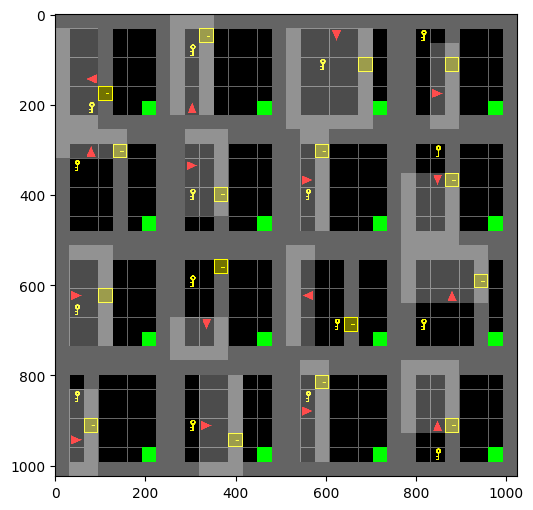

In [14]:
import matplotlib.pyplot as plt

env_name = 'MiniGrid-DoorKey-8x8-v0'
#env_name = 'MiniGrid-WallGapS6-v0'
#env_name = 'MiniGrid-LavaGapS6-v0'

# Create vectorized environment with wrapper class
vec_env = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=FlatObsWrapper)

# Plot snapshot of vectorized environment and check randomized init
vec_env.reset()
before_img = vec_env.render('rgb_array')

plt.figure(figsize = (6.,6.))
plt.imshow(before_img);

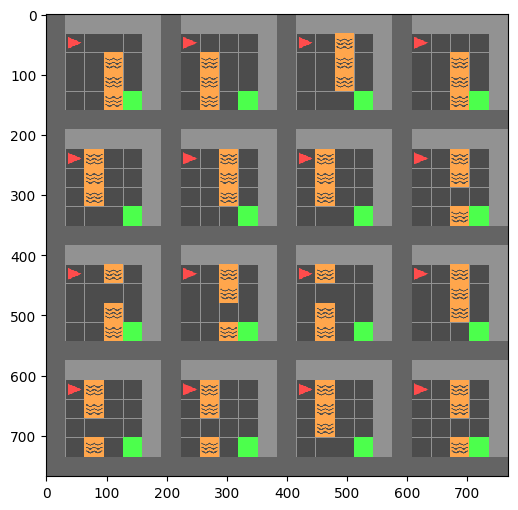

In [12]:
import matplotlib.pyplot as plt

#env_name = 'MiniGrid-DoorKey-6x6-v0'
#env_name = 'MiniGrid-WallGapS6-v0'
env_name = 'MiniGrid-LavaGapS6-v0'

# Create vectorized environment with wrapper class
vec_env = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=ImgRGBImgPartialObsWrapper)

# Plot snapshot of vectorized environment and check randomized init
vec_env.reset()
before_img = vec_env.render('rgb_array')

plt.figure(figsize = (6.,6.))
plt.imshow(before_img);